In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
from battery import Battery

In [3]:
# Load the data
df = pd.read_csv('trimmed_data.csv')

In [4]:
#drop unneeded comlumns
df.drop(columns=['Beam Irradiance (W/m2)'], inplace=True)
df.drop(columns=['Diffuse Irradiance (W/m2)'], inplace=True)
df.drop(columns=['Ambient Temperature (C)'], inplace=True)
df.drop(columns=['Wind Speed (m/s)'], inplace=True)
df.drop(columns=['Plane of Array Irradiance (W/m2)'], inplace=True)
df.drop(columns=['Cell Temperature (C)'], inplace=True)
df.drop(columns=['DC Array Output (W)'], inplace=True)

In [5]:


# Add a dummy year column (if not already present)
df['year'] = 2023

# Create a datetime column
df['datetime'] = pd.to_datetime(df[['year', 'Month', 'Day', 'Hour']])

# Set datetime as the index
df.set_index('datetime', inplace=True)

# Drop the dummy year column as it is no longer needed
df.drop(columns=['year'], inplace=True)

df

,Month,Day,Hour,AC System Output (W)
datetime,,,,
2023-01-01 08:00:00,1,1,8,5.264381e+06
2023-01-01 09:00:00,1,1,9,1.975484e+07
2023-01-01 10:00:00,1,1,10,3.243536e+07
2023-01-01 11:00:00,1,1,11,3.411719e+07
2023-01-01 12:00:00,1,1,12,3.316971e+07
...,...,...,...,...
2023-12-31 12:00:00,12,31,12,9.033082e+07
2023-12-31 13:00:00,12,31,13,9.309686e+07
2023-12-31 14:00:00,12,31,14,9.871630e+07


In [6]:
# Initialize the electricity consumption column
electricity_consumption = pd.Series(0,index=df.index)
excess_generated = pd.Series(0,index=df.index)
under_threshold = pd.Series(0, index=df.index)
new_electricity_consumption=pd.Series(0,index=df.index)
ac_output_mw=pd.Series(0,index=df.index)
Battery_10MW_30MWh_Series=pd.Series(0,index=df.index)
Battery_20MW_60MWh_Series=pd.Series(0,index=df.index)
max_consumption=90
min_consumption=6

#initialize 2 batteries
Battery_20MW_60MWh=Battery(power_capacity=20,energy_capacity=60,efficiency=1)
Battery_10MW_30MWh=Battery(power_capacity=10,energy_capacity=30,efficiency=1)
Battery_12MW_90MWh=Battery(power_capacity=12,energy_capacity=90,efficiency=1)

print(electricity_consumption.dtype)
print(new_electricity_consumption.dtype)



int64
int64


In [7]:


# Apply the conditions on an hourly basis
for date, ac_output in df['AC System Output (W)'].items():
    ac_output_mw[date] = ac_output / 1e6  # Convert W to MW
    
    if ac_output_mw[date] > min_consumption:
        # Cap the AC output at 90 MW for consumption calculations
        if ac_output_mw[date] > max_consumption:
            
            electricity_consumption[date] = max_consumption
            new_electricity_consumption[date] = max_consumption
            excess_generated[date]=ac_output_mw[date]-max_consumption
            
            #charge battery with excess 
            Battery_10MW_30MWh.charge(power=excess_generated[date])
            Battery_20MW_60MWh.charge(power=excess_generated[date])
            
            # the battery to be used is Battery_12MW_90MWh
            Battery_12MW_90MWh.charge(power=excess_generated[date])
            
            
        else:
            electricity_consumption[date] = ac_output_mw[date]
    else:
        electricity_consumption[date] = 0
        under_threshold[date]=ac_output_mw[date]
        new_electricity_consumption[date]=Battery_20MW_60MWh.discharge(power=10.5-under_threshold[date])+ac_output_mw[date]
        
        
        
        
        
new_electricity_consumption

C:\Users\alyou\AppData\Local\Temp\ipykernel_17772\41558447.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ac_output_mw[date] = ac_output / 1e6  # Convert W to MW
C:\Users\alyou\AppData\Local\Temp\ipykernel_17772\41558447.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  under_threshold[date]=ac_output_mw[date]
C:\Users\alyou\AppData\Local\Temp\ipykernel_17772\41558447.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

datetime
2023-01-01 08:00:00     5.264381
2023-01-01 09:00:00     0.000000
2023-01-01 10:00:00     0.000000
2023-01-01 11:00:00     0.000000
2023-01-01 12:00:00     0.000000
                         ...    
2023-12-31 12:00:00    90.000000
2023-12-31 13:00:00    90.000000
2023-12-31 14:00:00    90.000000
2023-12-31 15:00:00     0.000000
2023-12-31 16:00:00     0.000000
Length: 4286, dtype: float64

In [8]:
data_break_down=pd.concat([ac_output_mw,electricity_consumption,excess_generated,under_threshold],axis=1)
data_break_down.columns = ['Total Power Output (MW)', 'Energy Consumption (MW)', 'Power Generated >90(MW)','Power Generated <10(MW)']
data_break_down['Total Redundancy(MW)']=data_break_down['Power Generated >90(MW)'] + data_break_down['Power Generated <10(MW)']
data_break_down

,Total Power Output (MW),Energy Consumption (MW),Power Generated >90(MW),Power Generated <10(MW),Total Redundancy(MW)
datetime,,,,,
2023-01-01 08:00:00,5.264381,0.000000,0.000000,5.264381,5.264381
2023-01-01 09:00:00,19.754844,19.754844,0.000000,0.000000,0.000000
2023-01-01 10:00:00,32.435363,32.435363,0.000000,0.000000,0.000000
2023-01-01 11:00:00,34.117193,34.117193,0.000000,0.000000,0.000000
2023-01-01 12:00:00,33.169710,33.169710,0.000000,0.000000,0.000000
...,...,...,...,...,...
2023-12-31 12:00:00,90.330822,90.000000,0.330822,0.000000,0.330822
2023-12-31 13:00:00,93.096864,90.000000,3.096864,0.000000,3.096864
2023-12-31 14:00:00,98.716296,90.000000,8.716296,0.000000,8.716296


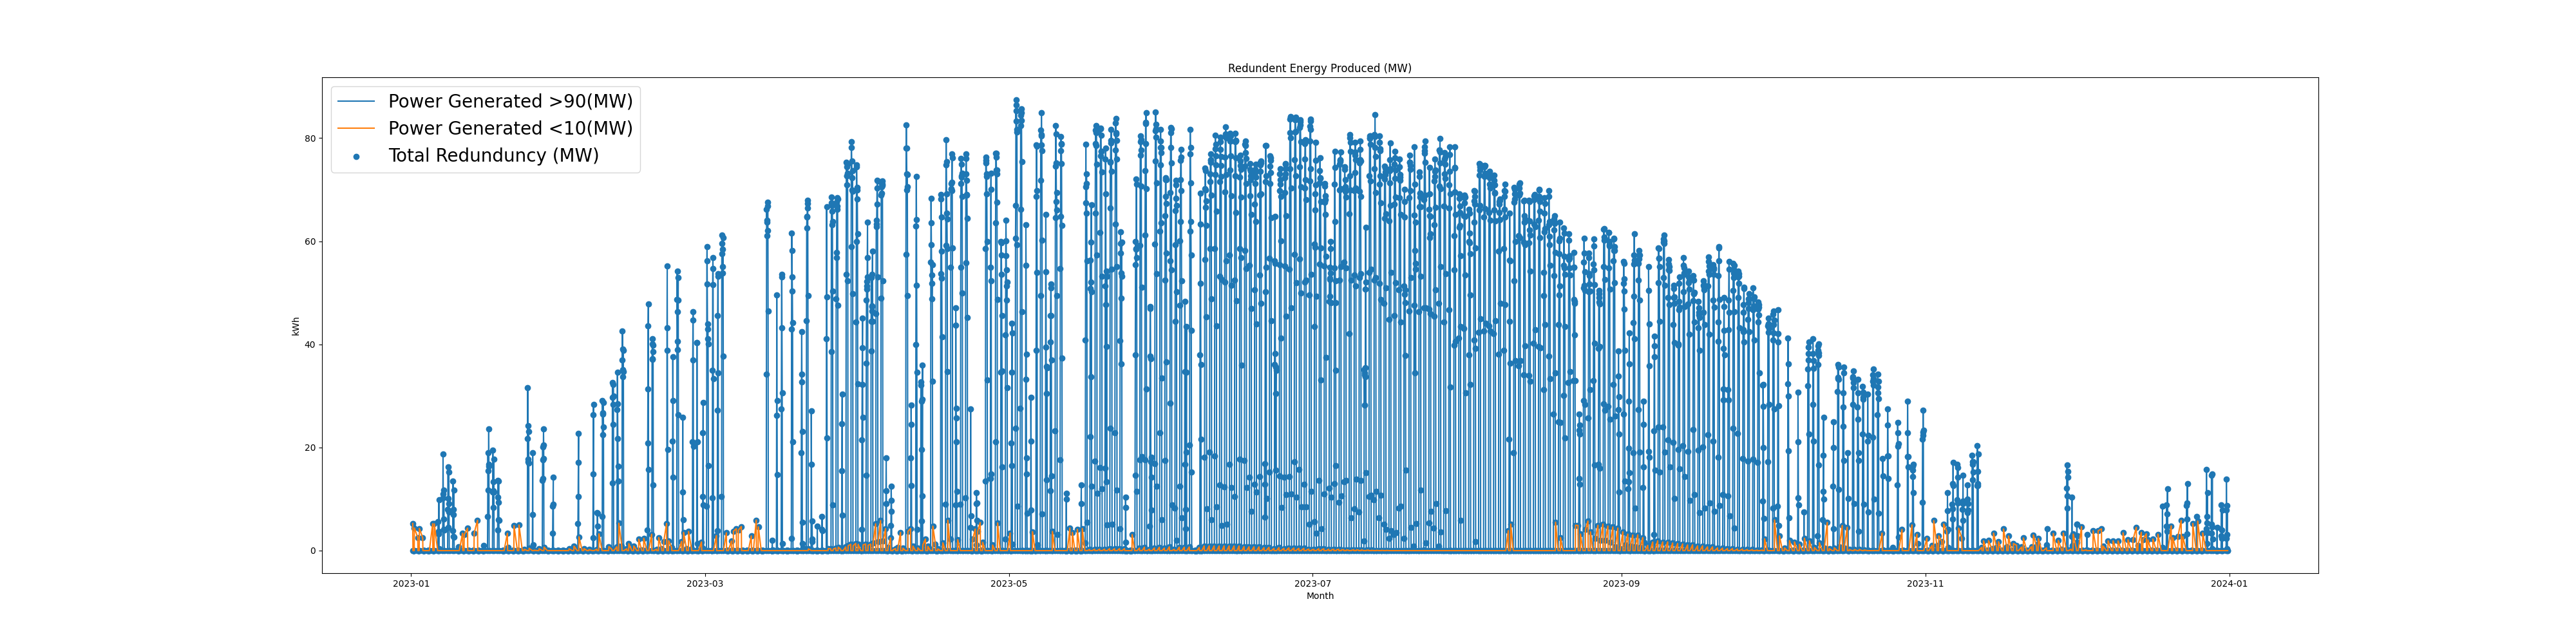

In [9]:


plt.figure(figsize=(40, 10))
plt.plot(data_break_down.index,data_break_down['Power Generated >90(MW)'],label='Power Generated >90(MW)')
plt.plot(data_break_down.index,data_break_down['Power Generated <10(MW)'],label='Power Generated <10(MW)')
plt.scatter(data_break_down.index,data_break_down["Total Redundancy(MW)"],label='Total Redunduncy (MW)')

plt.title('Redundent Energy Produced (MW)')
plt.xlabel('Month')
plt.ylabel('kWh')
plt.legend(loc='upper left', fontsize=20, prop={'size': 20})

In [10]:
daily_data_break_down=data_break_down.resample('D').sum()
daily_data_break_down

,Total Power Output (MW),Energy Consumption (MW),Power Generated >90(MW),Power Generated <10(MW),Total Redundancy(MW)
datetime,,,,,
2023-01-01,188.639443,178.983952,0.000000,9.655491,9.655491
2023-01-02,186.892944,180.039868,0.000000,6.853076,6.853076
2023-01-03,239.350879,236.869482,0.000000,2.481397,2.481397
2023-01-04,457.561323,457.561323,0.000000,0.000000,0.000000
2023-01-05,191.235575,180.836500,0.000000,10.399075,10.399075
...,...,...,...,...,...
2023-12-27,735.469311,687.525815,47.943496,0.000000,47.943496
2023-12-28,734.400080,689.067319,45.332762,0.000000,45.332762
2023-12-29,513.887174,509.350523,4.536651,0.000000,4.536651


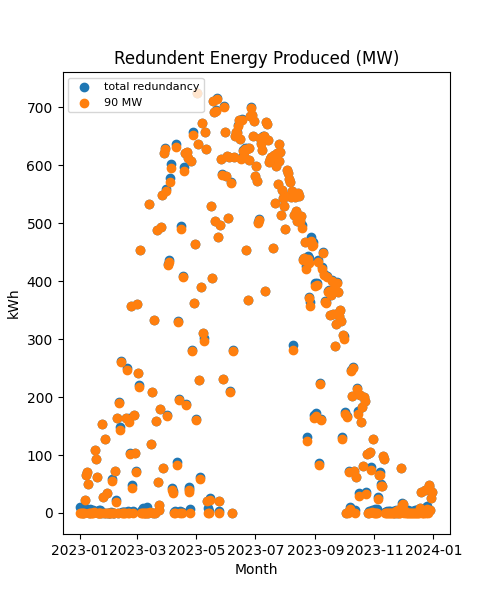

In [18]:
plt.figure(figsize=(20, 10))
plt.scatter(daily_data_break_down.index,daily_data_break_down['Total Redundancy(MW)'],label='total redundancy')
plt.scatter(daily_data_break_down.index,daily_data_break_down['Power Generated >90(MW)'],label='90 MW')


plt.title('Redundent Energy Produced (MW)')
plt.xlabel('Month')
plt.ylabel('kWh')

plt.legend(loc='upper left', fontsize=8, prop={'size': 8})


In [12]:
daily_data_break_down.to_csv('daily_data_break_down.csv')

In [13]:
data_break_down.to_csv('data_break_down.csv')

In [14]:
data_break_down.max()

Total Power Output (MW)    177.427310
Energy Consumption (MW)     90.000000
Power Generated >90(MW)     87.427310
Power Generated <10(MW)      5.944749
Total Redundancy(MW)        87.427310
dtype: float64

In [15]:
numbers=daily_data_break_down.value_counts()
numbers.head()

Total Power Output (MW)  Energy Consumption (MW)  Power Generated >90(MW)  Power Generated <10(MW)  Total Redundancy(MW)
133.987865               128.891546               0.000000                 5.096319                 5.096319                1
1393.192089              950.363575               438.762400               4.066115                 442.828515              1
1381.955050              945.481194               433.672619               2.801237                 436.473856              1
1379.737886              954.276270               420.536393               4.925222                 425.461615              1
1374.623811              934.322436               430.952856               9.348518                 440.301374              1
Name: count, dtype: int64

In [16]:
#i want to see the numbers in descending order
numbers.sort_values(ascending=False)

Total Power Output (MW)  Energy Consumption (MW)  Power Generated >90(MW)  Power Generated <10(MW)  Total Redundancy(MW)
133.987865               128.891546               0.000000                 5.096319                 5.096319                1
258.087102               255.579718               0.000000                 2.507384                 2.507384                1
142.616799               135.310190               0.000000                 7.306609                 7.306609                1
161.872709               159.918888               0.000000                 1.953821                 1.953821                1
168.403067               162.846961               0.000000                 5.556107                 5.556107                1
                                                                                                                           ..
1760.360266              1060.277040              699.435687               0.647539                 700.083226             

C:\Users\alyou\AppData\Local\Temp\ipykernel_17772\2521385448.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_break_down=data_break_down.resample('M').sum()


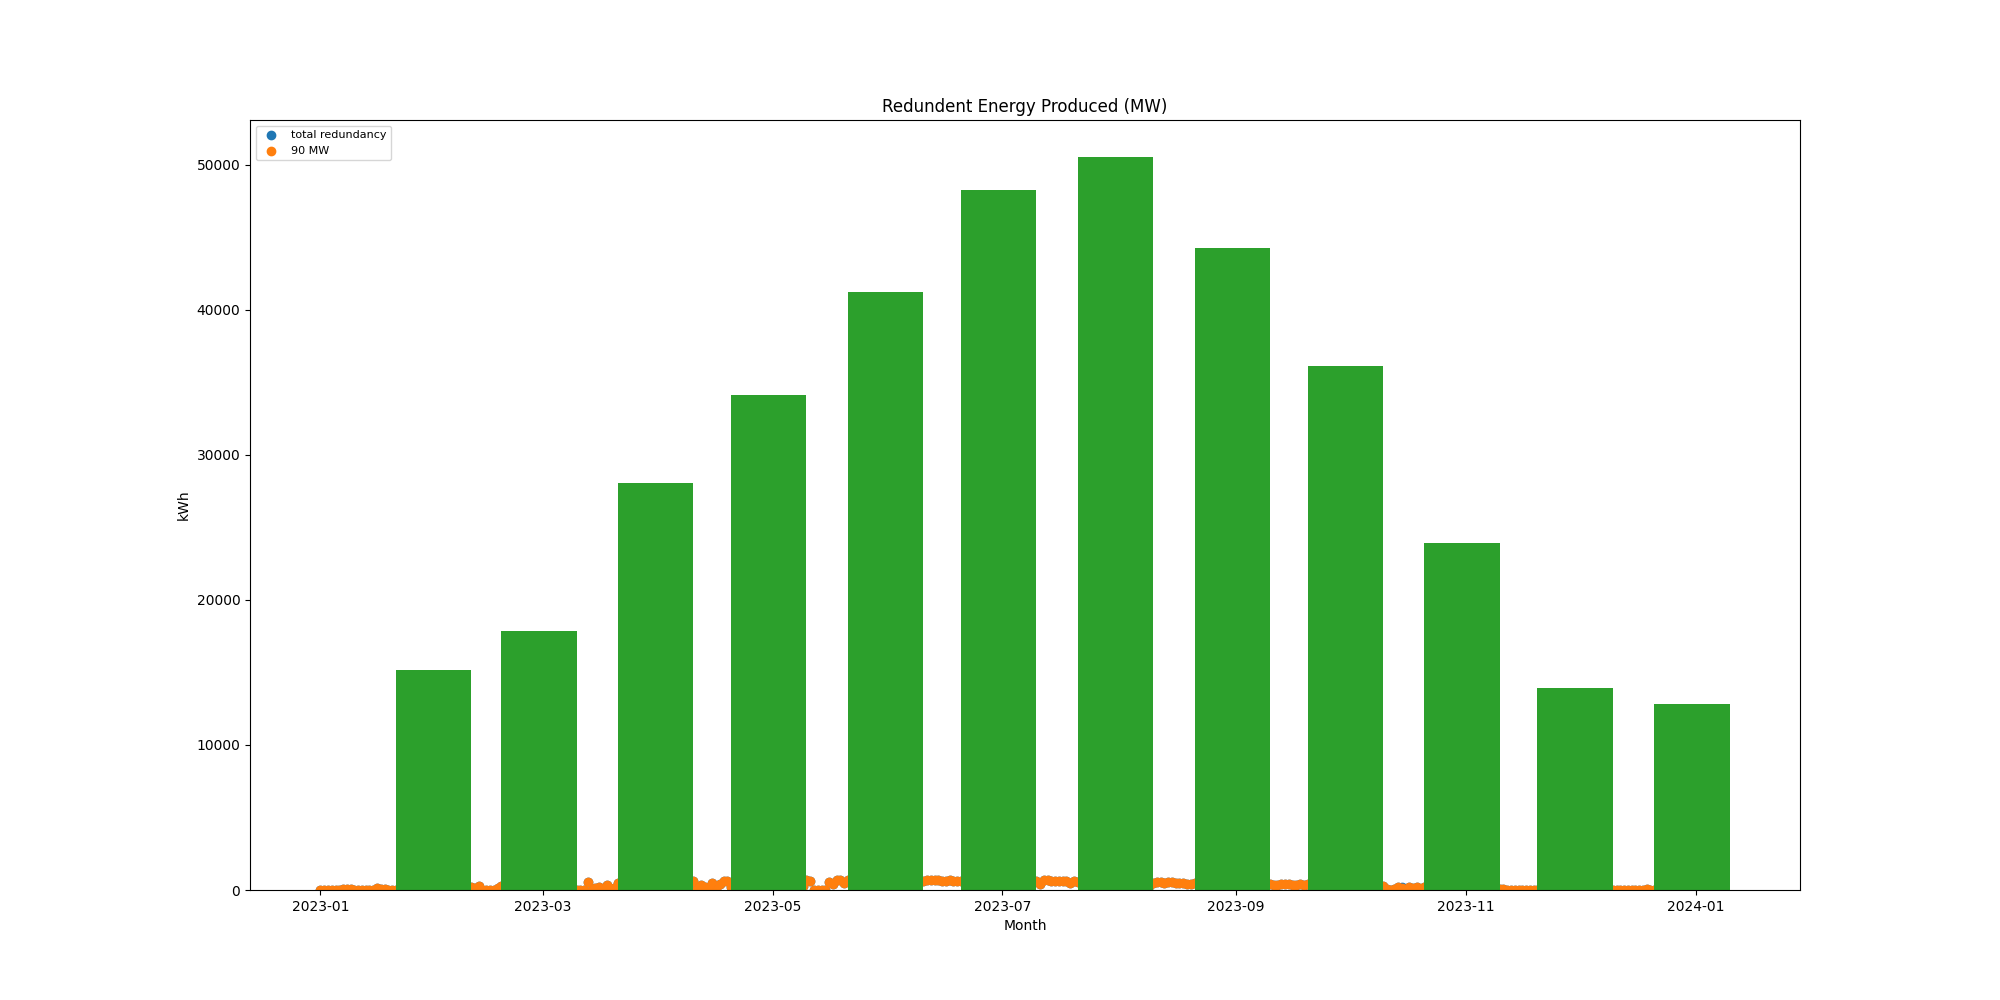

In [17]:
monthly_data_break_down=data_break_down.resample('M').sum()

plt.bar(monthly_data_break_down.index,monthly_data_break_down['Total Power Output (MW)'],label='total redundancy',width=20)
plt.show()